In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
def demand_sales_dgp(
    rng_key: ArrayImpl, n: int
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl, ArrayImpl]:
    t = jnp.arange(start=0, stop=n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = 0.3 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = 0.5 * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(rng_subkey, 0.9, shape=(t.size,))

    for i in range(2, t.size):
        demand_i = (
            0.6 * demand[i - 1]
            + 0.3 * demand[i - 1]
            + 0.5 * jnp.sin(2 * jnp.pi * t[i] / 7)
            + 0.2
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - 0.2
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


n = 200
rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, n)

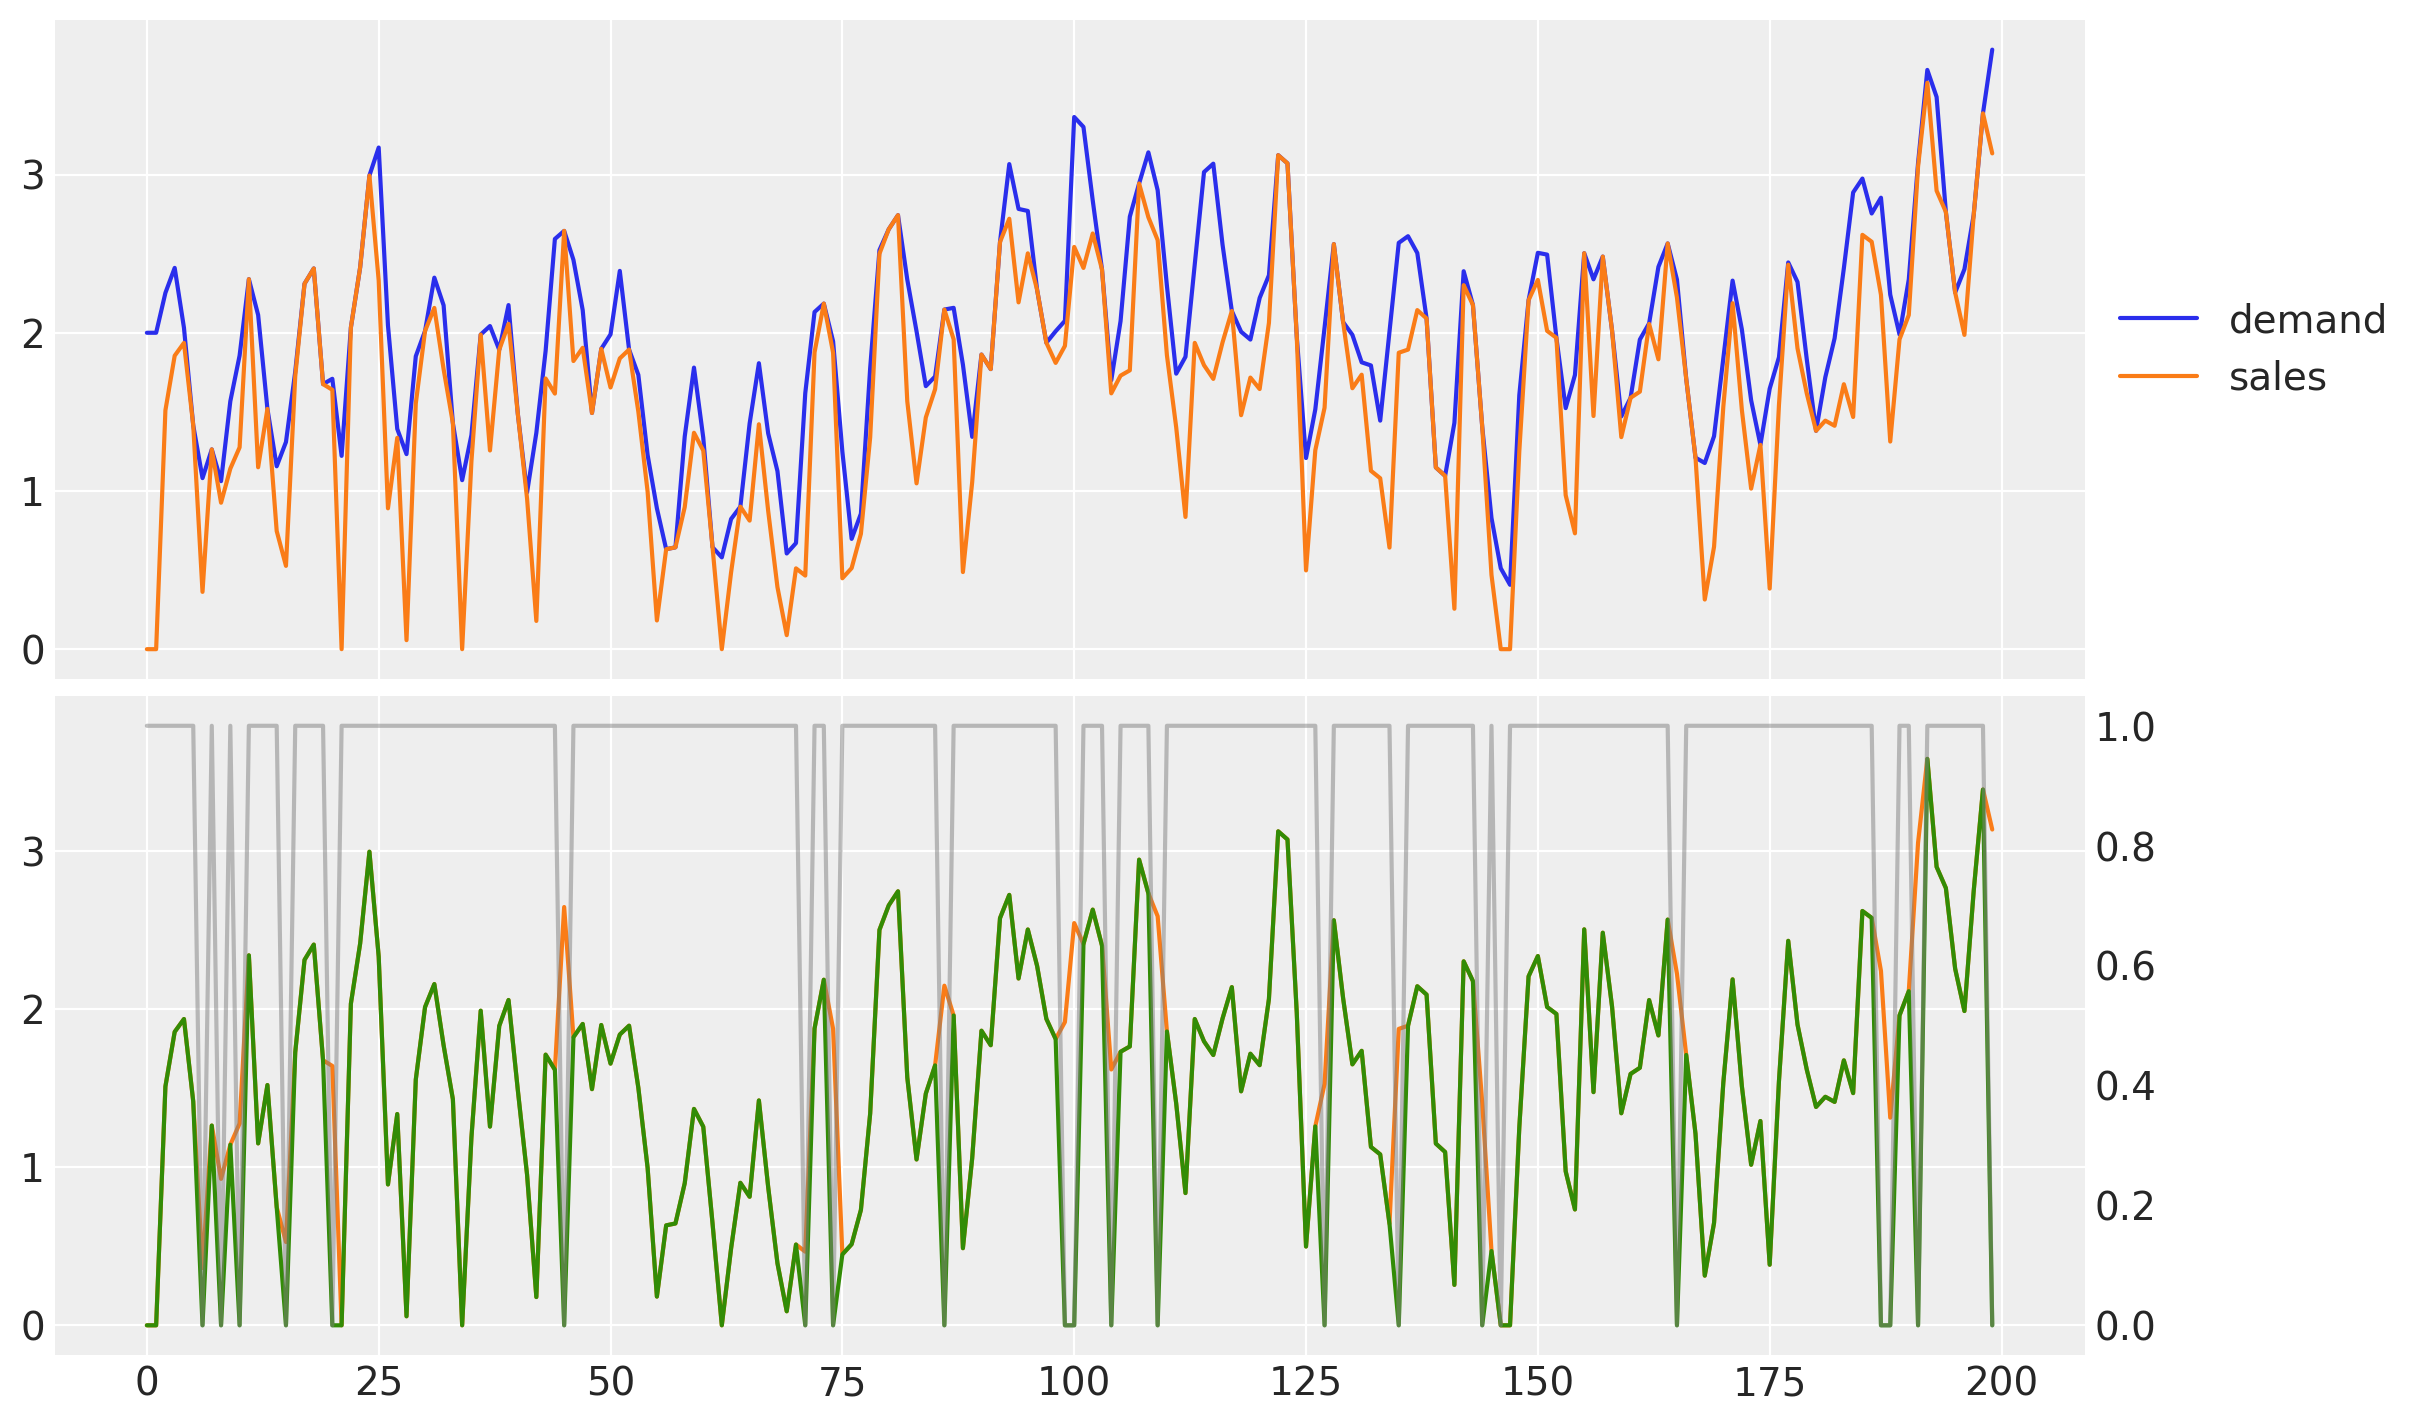

In [3]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="C0", label="demand")
ax[0].plot(t, sales, c="C1", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax[1].plot(t, sales, c="C1", label="sales")
ax[1].plot(t, sales_obs, c="C2", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax1_twin.grid(False)
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))